In [1]:
try:
    reload(galpy.df_src.streampepperdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamgapdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streampepperdf
import time
import numpy
from scipy import signal, ndimage
import statsmodels.api as sm
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_coords
from galpy.util import bovy_plot
%pylab inline
import seaborn as sns
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


In [2]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [3]:
sdf_pepper_2impacts= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    impactb=[0.1/R0,0./R0],
    subhalovel=numpy.array([[36.82200571,102.7700529,169.4174464],
                            [6.82200571,132.7700529,149.4174464]])/V0,
    timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),1.88/bovy_conversion.time_in_Gyr(V0,R0)],
    impact_angle=[-1.34,-0.34],
    GM=[10.**-2.2/bovy_conversion.mass_in_1010msol(V0,R0),10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
    rs=[0.55/R0,0.625/R0],
    spline_order=1) 

In [12]:
def nsubhalo(m):
    return 0.3*(10.**6.5/m)
def rs(m):
    return 1.05/R0*(m/10.**8.)**0.5
def dNencdm(m,Xrs=3.):
    return 10.*sdf_pepper_2impacts.subhalo_encounters(sigma=120./220.,nsubhalo=nsubhalo(m),bmax=Xrs*rs(m))

In [13]:
m=10.**5.5
sdf_pepper_2impacts.simulate(rate=dNencdm(m,Xrs=3.),
                            sample_GM=lambda: m/10.**10./bovy_conversion.mass_in_1010msol(V0,R0),
                            sample_rs=lambda x: rs(x*bovy_conversion.mass_in_1010msol(V0,R0)*10.**10.),
                            Xrs=3.)

(array([ 0.64306728,  0.59035684,  0.42168346,  0.40059929,  0.40059929,
         0.47439389,  0.41114137,  0.40059929,  0.47439389,  0.41114137]),
 array([ 0.00664769,  0.22272487,  0.43880205,  0.65487923,  0.87095641,
         1.08703359,  1.30311077,  1.51918795,  1.73526513,  1.95134231,
         2.16741949]),
 <a list of 1 Patch objects>)

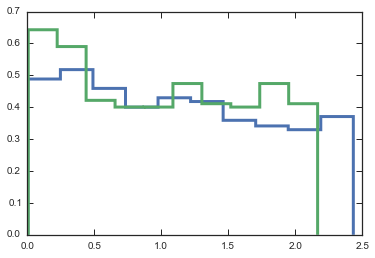

In [31]:
hist(-sdf_pepper_2impacts._impact_angle[sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[0]],
    normed=True,histtype='step',lw=3.)
hist(-sdf_pepper_2impacts._impact_angle[sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[1]],
    normed=True,histtype='step',lw=3.)

In [18]:
print numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[0]), \
    sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[0]]
print numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[1]), \
    sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[1]]

699 4.04452818914
439 2.29096398656


In [20]:
print numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[0])/sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[0]]
print numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[1])/sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[1]]

172.826091774
191.622392397


In [22]:
print numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[0])/float(numpy.sum(sdf_pepper_2impacts._timpact == sdf_pepper_2impacts._uniq_timpact[1]))
print sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[0]]/sdf_pepper_2impacts._stream_len[sdf_pepper_2impacts._uniq_timpact[1]]

1.59225512528
1.76542635016


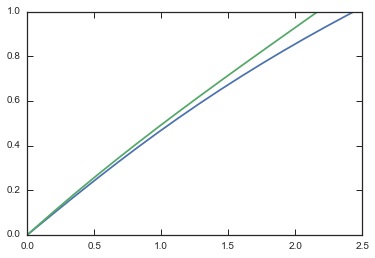

In [32]:
qs= numpy.linspace(0.,1.,1001)
plot(sdf_pepper_2impacts._icdf_stream_len[sdf_pepper_2impacts._uniq_timpact[0]](qs),qs)
plot(sdf_pepper_2impacts._icdf_stream_len[sdf_pepper_2impacts._uniq_timpact[1]](qs),qs)

In [36]:
import pickle
du= pickle.dumps(sdf_pepper_2impacts,protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
len(du)

2123310037